# Head

In [1]:
import pandas as pd
from pathlib import Path
home = Path.home()

# models = ['gemma3', 'llama4', 'qwq', 'qwen3']
models = ['gemma3', 'llama4']

suffixes = None
# suffixes = '_sent_shuffle'
# suffixes = '_tail'
if suffixes is not None:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}{suffixes}.txt' for model in models]
else:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}.txt' for model in models]

df = pd.read_csv(home / 'projects/TLDR/data/paper_html_10.1038/abs_annotation/test.tsv', sep='\t')
for model, csv_file in zip(models, csv_files):
    single_df = pd.read_csv(csv_file, sep='\t', header=None, names=[model])
    df = df.join(single_df)

for index in pd.read_csv(home / "projects/TLDR/description/invalid_entry_in_test.txt", sep='\t', header=None).values.flatten().tolist():
    df = df.drop(index-2)  # Adjusting for zero-based index
df

,doi,paper_id,abstract,annotation,gemma3,llama4
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study refutes the single origin of domest...,This study suggests that there were two distin...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides evidence for independent d...,"This study, among others, provides evidence of..."
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study used fine-mapping methods to identi...,The study describes the fine-mapping approach ...
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,Reference 35 reports long-range LD in Dutch bl...,This study demonstrated that linkage disequili...
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study identifies a major QTL on SSC4 affe...,The data reported here constitute a comprehens...
...,...,...,...,...,...,...
35631,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study describes an efficient protocol for...,These studies suggest that isolation and expan...
35632,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,Reference 48 describes the engineering of a sy...,This study demonstrates that orthogonal IL-2 a...
35633,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,Reference 51 shows that autoreactive T cells c...,This study identifies an important mechanism u...
35634,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This work demonstrates that a combined strateg...,This study presents a comprehensive strategy t...


# Fetch and save metrics

In [3]:
import pandas as pd
from sqlalchemy import create_engine
from tqdm import tqdm
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

MYSQL_HOST = os.getenv('MYSQL_HOST')
MYSQL_USER = os.getenv('MYSQL_USER')
MYSQL_PASS = os.getenv('MYSQL_PASS')
MYSQL_DB = os.getenv('MYSQL_DB')

engine = create_engine(f'mysql+pymysql://{MYSQL_USER}:{MYSQL_PASS}@{MYSQL_HOST}/{MYSQL_DB}?charset=utf8mb4')

paper_ids = df['paper_id'].unique().tolist()
BATCH_SIZE = 500  # 每批查多少条，可调大或调小

results = []
for i in tqdm(range(0, len(paper_ids), BATCH_SIZE), desc="Querying titles", unit="batch"):
    batch = paper_ids[i:i+BATCH_SIZE]
    id_str = ','.join(str(int(pid)) for pid in batch)
    sql = f"SELECT paper_id, C3, C10, C_total, beauty_coefficient, awakening_year FROM paper_metrics WHERE paper_id IN ({id_str})"
    batch_df = pd.read_sql(sql, engine)
    results.append(batch_df)

paper_metrics_df = pd.concat(results, ignore_index=True)
display(paper_metrics_df)

Querying titles:   0%|                                                                                                         | 0/59 [00:00<?, ?batch/s]

Querying titles: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 19.40batch/s]


,paper_id,C3,C10,C_total,beauty_coefficient,awakening_year
0,1353153,35.0,80.0,119,0.0000,2000
1,1634910,16.0,43.0,61,4.5000,2006
2,1655469,17.0,42.0,63,0.0000,2000
3,1778349,78.0,226.0,292,0.3214,1999
4,2550721,22.0,49.0,66,0.6250,2001
...,...,...,...,...,...,...
29211,135559127,NaN,NaN,5,0.0000,2021
29212,136137471,NaN,NaN,210,0.0000,2022
29213,136366684,NaN,NaN,107,0.0000,2022
29214,136374303,NaN,NaN,33,0.0000,2022


In [4]:
paper_metrics_df.fillna(0, inplace=True)
paper_metrics_df['C3'] = paper_metrics_df['C3'].astype(int)
paper_metrics_df['C10'] = paper_metrics_df['C10'].astype(int)
paper_metrics_df['C_total'] = paper_metrics_df['C_total'].astype(int)
display(paper_metrics_df)
paper_metrics_df.to_parquet(home / 'projects/TLDR/data/paper_metrics.parquet', index=False)

,paper_id,C3,C10,C_total,beauty_coefficient,awakening_year
0,1353153,35,80,119,0.0000,2000
1,1634910,16,43,61,4.5000,2006
2,1655469,17,42,63,0.0000,2000
3,1778349,78,226,292,0.3214,1999
4,2550721,22,49,66,0.6250,2001
...,...,...,...,...,...,...
29211,135559127,0,0,5,0.0000,2021
29212,136137471,0,0,210,0.0000,2022
29213,136366684,0,0,107,0.0000,2022
29214,136374303,0,0,33,0.0000,2022


# Load paper metrics

In [2]:
paper_metrics_df = pd.read_parquet(home / 'projects/TLDR/data/paper_metrics.parquet')

df = pd.merge(df, paper_metrics_df, on='paper_id', how='left')
df.fillna(0, inplace=True)
df['C3'] = df['C3'].astype(int)
df['C10'] = df['C10'].astype(int)
df['C_total'] = df['C_total'].astype(int)
df['awakening_year'] = df['awakening_year'].astype(int)

display(df)

,doi,paper_id,abstract,annotation,gemma3,llama4,C3,C10,C_total,beauty_coefficient,awakening_year
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study refutes the single origin of domest...,This study suggests that there were two distin...,12,90,516,7.7912,2017
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides evidence for independent d...,"This study, among others, provides evidence of...",21,53,149,165.3750,2020
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study used fine-mapping methods to identi...,The study describes the fine-mapping approach ...,21,67,97,-1.0600,2001
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,Reference 35 reports long-range LD in Dutch bl...,This study demonstrated that linkage disequili...,28,156,249,1.6553,2005
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study identifies a major QTL on SSC4 affe...,The data reported here constitute a comprehens...,69,196,426,0.0000,1994
...,...,...,...,...,...,...,...,...,...,...,...
35616,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study describes an efficient protocol for...,These studies suggest that isolation and expan...,64,216,286,-0.1667,2010
35617,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,Reference 48 describes the engineering of a sy...,This study demonstrates that orthogonal IL-2 a...,136,0,239,0.0197,2019
35618,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,Reference 51 shows that autoreactive T cells c...,This study identifies an important mechanism u...,189,0,388,-0.2716,2017
35619,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This work demonstrates that a combined strateg...,This study presents a comprehensive strategy t...,155,0,210,-0.3491,2021


# Match MAG PaperID

In [3]:
import pickle
print("Loading doi_mag_pid_dict...")
with open(home / "projects/TLDR/data/doi_mag_pid_dict.pkl", "rb") as f:
    doi_mag_pid_dict = pickle.load(f)
    print("doi_mag_pid_dict loaded.")

df['mag_pid'] = df['doi'].map(doi_mag_pid_dict)
df = df.dropna(subset=['mag_pid'])
df.loc[:, 'mag_pid'] = df['mag_pid'].apply(lambda x: x.split(';')[0] if isinstance(x, str) else x)
df.loc[:, 'mag_pid'] = df['mag_pid'].astype(int)
display(df)

Loading doi_mag_pid_dict...
doi_mag_pid_dict loaded.


,doi,paper_id,abstract,annotation,gemma3,llama4,C3,C10,C_total,beauty_coefficient,awakening_year,mag_pid
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study refutes the single origin of domest...,This study suggests that there were two distin...,12,90,516,7.7912,2017,2005395185
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides evidence for independent d...,"This study, among others, provides evidence of...",21,53,149,165.3750,2020,2110049233
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study used fine-mapping methods to identi...,The study describes the fine-mapping approach ...,21,67,97,-1.0600,2001,2082900742
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,Reference 35 reports long-range LD in Dutch bl...,This study demonstrated that linkage disequili...,28,156,249,1.6553,2005,2103106090
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study identifies a major QTL on SSC4 affe...,The data reported here constitute a comprehens...,69,196,426,0.0000,1994,2045457895
...,...,...,...,...,...,...,...,...,...,...,...,...
35616,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study describes an efficient protocol for...,These studies suggest that isolation and expan...,64,216,286,-0.1667,2010,2137227986
35617,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,Reference 48 describes the engineering of a sy...,This study demonstrates that orthogonal IL-2 a...,136,0,239,0.0197,2019,2789780246
35618,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,Reference 51 shows that autoreactive T cells c...,This study identifies an important mechanism u...,189,0,388,-0.2716,2017,2266478788
35619,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This work demonstrates that a combined strateg...,This study presents a comprehensive strategy t...,155,0,210,-0.3491,2021,2943378944


# Load publication venue and year from MAG

In [4]:
MAG_paper_df = pd.read_parquet(home / 'projects/TLDR/data/MAG_paper.parquet')
df = df.merge(MAG_paper_df[['VenueID', 'Year']], left_on='mag_pid', right_index=True, how='inner')
df.rename(columns={'VenueID': 'mag_vid', 'Year': 'year'}, inplace=True)
display(df)

,doi,paper_id,abstract,annotation,gemma3,llama4,C3,C10,C_total,beauty_coefficient,awakening_year,mag_pid,mag_vid,year
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study refutes the single origin of domest...,This study suggests that there were two distin...,12,90,516,7.7912,2017,2005395185,125754415,1994
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides evidence for independent d...,"This study, among others, provides evidence of...",21,53,149,165.3750,2020,2110049233,65932378,2000
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study used fine-mapping methods to identi...,The study describes the fine-mapping approach ...,21,67,97,-1.0600,2001,2082900742,125754415,1999
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,Reference 35 reports long-range LD in Dutch bl...,This study demonstrated that linkage disequili...,28,156,249,1.6553,2005,2103106090,43092948,2000
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study identifies a major QTL on SSC4 affe...,The data reported here constitute a comprehens...,69,196,426,0.0000,1994,2045457895,3880285,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35616,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study describes an efficient protocol for...,These studies suggest that isolation and expan...,64,216,286,-0.1667,2010,2137227986,129060628,2009
35617,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,Reference 48 describes the engineering of a sy...,This study demonstrates that orthogonal IL-2 a...,136,0,239,0.0197,2019,2789780246,3880285,2018
35618,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,Reference 51 shows that autoreactive T cells c...,This study identifies an important mechanism u...,189,0,388,-0.2716,2017,2266478788,3880285,2016
35619,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This work demonstrates that a combined strateg...,This study presents a comprehensive strategy t...,155,0,210,-0.3491,2021,2943378944,125754415,2019


# Load subject label

In [5]:
label_df = pd.read_parquet(home / 'projects/TLDR/data/cluster_df.parquet')
label_df

,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,spectral_label,n2v_kmeans_label,cm_kmeans_label,gnn_kmeans_label,bert_kmeans_label
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711,24,3,21,0,0
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494,24,20,21,0,3
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081,24,20,21,0,0
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582,24,20,21,0,3
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758,14,4,24,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015,8,18,1,19,1
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642,21,5,1,14,1
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660,21,5,1,14,1
121509672,Agricultural and Biological Sciences,5,0.179111,-36.757057,-0.591017,21,0.430040,16,0.207435,10,5,1,10,1


In [6]:
df = df.merge(label_df[['kmeans_label', 'Scopus_label']], left_on='mag_vid', right_index=True, how='inner')
df.rename(columns={'kmeans_label': 'p2v_label', 'Scopus_label': 'scopus_label'}, inplace=True)
df

,doi,paper_id,abstract,annotation,gemma3,llama4,C3,C10,C_total,beauty_coefficient,awakening_year,mag_pid,mag_vid,year,p2v_label,scopus_label
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study refutes the single origin of domest...,This study suggests that there were two distin...,12,90,516,7.7912,2017,2005395185,125754415,1994,17,Multidisciplinary
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides evidence for independent d...,"This study, among others, provides evidence of...",21,53,149,165.3750,2020,2110049233,65932378,2000,17,"Biochemistry, Genetics and Molecular Biology"
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study used fine-mapping methods to identi...,The study describes the fine-mapping approach ...,21,67,97,-1.0600,2001,2082900742,125754415,1999,17,Multidisciplinary
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,Reference 35 reports long-range LD in Dutch bl...,This study demonstrated that linkage disequili...,28,156,249,1.6553,2005,2103106090,43092948,2000,17,"Biochemistry, Genetics and Molecular Biology"
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study identifies a major QTL on SSC4 affe...,The data reported here constitute a comprehens...,69,196,426,0.0000,1994,2045457895,3880285,1994,8,Multidisciplinary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35616,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study describes an efficient protocol for...,These studies suggest that isolation and expan...,64,216,286,-0.1667,2010,2137227986,129060628,2009,17,Medicine
35617,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,Reference 48 describes the engineering of a sy...,This study demonstrates that orthogonal IL-2 a...,136,0,239,0.0197,2019,2789780246,3880285,2018,8,Multidisciplinary
35618,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,Reference 51 shows that autoreactive T cells c...,This study identifies an important mechanism u...,189,0,388,-0.2716,2017,2266478788,3880285,2016,8,Multidisciplinary
35619,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This work demonstrates that a combined strateg...,This study presents a comprehensive strategy t...,155,0,210,-0.3491,2021,2943378944,125754415,2019,17,Multidisciplinary


# Load paper title

In [7]:
df = pd.merge(df, pd.read_parquet(home / 'projects/TLDR/data/paper_title.parquet'), on='paper_id', how='left')
df

,doi,paper_id,abstract,annotation,gemma3,llama4,C3,C10,C_total,beauty_coefficient,awakening_year,mag_pid,mag_vid,year,p2v_label,scopus_label,title
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study refutes the single origin of domest...,This study suggests that there were two distin...,12,90,516,7.7912,2017,2005395185,125754415,1994,17,Multidisciplinary,Evidence for two independent domestications of...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides evidence for independent d...,"This study, among others, provides evidence of...",21,53,149,165.3750,2020,2110049233,65932378,2000,17,"Biochemistry, Genetics and Molecular Biology",The Origin of the Domestic Pig: Independent Do...
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study used fine-mapping methods to identi...,The study describes the fine-mapping approach ...,21,67,97,-1.0600,2001,2082900742,125754415,1999,17,Multidisciplinary,Fine-mapping of quantitative trait loci by ide...
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,Reference 35 reports long-range LD in Dutch bl...,This study demonstrated that linkage disequili...,28,156,249,1.6553,2005,2103106090,43092948,2000,17,"Biochemistry, Genetics and Molecular Biology",Extensive Genome-wide Linkage Disequilibrium i...
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study identifies a major QTL on SSC4 affe...,The data reported here constitute a comprehens...,69,196,426,0.0000,1994,2045457895,3880285,1994,8,Multidisciplinary,Genetic mapping of quantitative trait loci for...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34141,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study describes an efficient protocol for...,These studies suggest that isolation and expan...,64,216,286,-0.1667,2010,2137227986,129060628,2009,17,Medicine,Expansion of Human Regulatory T-Cells From Pat...
34142,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,Reference 48 describes the engineering of a sy...,This study demonstrates that orthogonal IL-2 a...,136,0,239,0.0197,2019,2789780246,3880285,2018,8,Multidisciplinary,Selective targeting of engineered T cells usin...
34143,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,Reference 51 shows that autoreactive T cells c...,This study identifies an important mechanism u...,189,0,388,-0.2716,2017,2266478788,3880285,2016,8,Multidisciplinary,Pathogenic CD4 T cells in type 1 diabetes reco...
34144,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This work demonstrates that a combined strateg...,This study presents a comprehensive strategy t...,155,0,210,-0.3491,2021,2943378944,125754415,2019,17,Multidisciplinary,Generation of hypoimmunogenic human pluripoten...


# Groupped

<Axes: xlabel='C_total', ylabel='Count'>

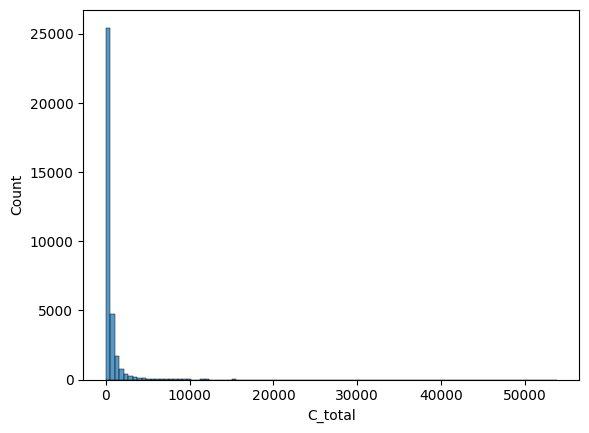

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['C_total'], bins=100)

In [25]:
df['C_total'].describe()

count    34146.000000
mean       568.506706
std       1423.307551
min          0.000000
25%        108.000000
50%        237.000000
75%        546.000000
max      53773.000000
Name: C_total, dtype: float64

## Subject prediction

In [30]:
df_q1 = df[(df['C_total']>=df['C_total'].quantile(0.75)) & (df['C_total'] <= df['C_total'].max())]
print(df_q1['p2v_label'].value_counts())

n_pos = len(df_q1[df_q1['p2v_label'] == 17])
n_neg = len(df_q1[df_q1['p2v_label'] != 17])
print("n_pos:", n_pos, "n_neg:",n_neg)
n_sample = min(n_pos, n_neg)

df_tar = pd.concat([df_q1[df_q1['p2v_label'] == 17].sample(n_sample, random_state=42), 
                    df_q1[df_q1['p2v_label'] != 17].sample(n_sample, random_state=42)], ignore_index=True)
print(len(df_tar))

p2v_label
8     4896
17    2988
9      126
6      102
7       99
11      73
4       63
22      41
18      37
12      36
21      29
5       10
20      10
1        8
24       7
15       6
3        5
2        4
23       3
0        2
16       1
13       1
Name: count, dtype: int64
n_pos: 2988 n_neg: 5559
5976


In [32]:
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from tqdm import tqdm

class ProgressHashingVectorizer(HashingVectorizer):
    """带进度条的HashingVectorizer"""
    def transform(self, X):
        if hasattr(X, '__len__'):
            self.n_samples_ = len(X)
            wrapped_X = tqdm(X, desc="Vectorizing documents", total=self.n_samples_)
            return super().transform(wrapped_X)
        return super().transform(X)

text_features = ['abstract', 'annotation'] + models
y = (df_tar['p2v_label'] == 17).astype(int)  # 17为1，否则为0

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

results = []
for feat in text_features:
    print(f"Processing feature: {feat}")
    X_text = df_tar[feat].astype(str).fillna('')
    vectorizer = ProgressHashingVectorizer(n_features=2**18, stop_words='english', alternate_sign=False)
    X = vectorizer.transform(X_text)
    clf = MultinomialNB()
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    res = {
        'feature': feat,
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'precision_mean': scores['test_precision'].mean(),
        'precision_std': scores['test_precision'].std(),
        'recall_mean': scores['test_recall'].mean(),
        'recall_std': scores['test_recall'].std(),
        'f1_mean': scores['test_f1'].mean(),
        'f1_std': scores['test_f1'].std(),
    }
    print(
        f"Feature: {feat} | "
        f"Acc: {res['accuracy_mean']:.4f}±{res['accuracy_std']:.4f} | "
        f"Precision: {res['precision_mean']:.4f}±{res['precision_std']:.4f} | "
        f"Recall: {res['recall_mean']:.4f}±{res['recall_std']:.4f} | "
        f"F1: {res['f1_mean']:.4f}±{res['f1_std']:.4f}"
    )
    results.append(res)

results_df = pd.DataFrame(results)
display(results_df)
print("gemma3 performance diff:", 
      results_df[results_df['feature']=='gemma3'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])
print("llama4 performance diff:", 
      results_df[results_df['feature']=='llama4'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])

Processing feature: abstract


Vectorizing documents:   0%|                                                                                                    | 0/5976 [00:00<?, ?it/s]

Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5976/5976 [00:00<00:00, 18583.32it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Feature: abstract | Acc: 0.7358±0.0291 | Precision: 0.6758±0.0130 | Recall: 0.9043±0.0725 | F1: 0.7726±0.0343
Processing feature: annotation


Vectorizing documents: 100%|█████████████████████████████████████████████████████████████████████████████████████| 5976/5976 [00:00<00:00, 113063.50it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Feature: annotation | Acc: 0.6394±0.0384 | Precision: 0.6337±0.0293 | Recall: 0.6516±0.0846 | F1: 0.6412±0.0567
Processing feature: gemma3


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5976/5976 [00:00<00:00, 99987.88it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Feature: gemma3 | Acc: 0.6941±0.0414 | Precision: 0.6765±0.0231 | Recall: 0.7373±0.0973 | F1: 0.7036±0.0590
Processing feature: llama4


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5976/5976 [00:00<00:00, 57670.91it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s


Feature: llama4 | Acc: 0.6601±0.0458 | Precision: 0.6438±0.0317 | Recall: 0.7061±0.0981 | F1: 0.6719±0.0634


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


,feature,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,abstract,0.735782,0.029143,0.675832,0.013024,0.904275,0.072497,0.772626,0.034266
1,annotation,0.639395,0.038386,0.633701,0.029326,0.651578,0.084603,0.641159,0.056749
2,gemma3,0.694113,0.041416,0.676550,0.023098,0.737275,0.097291,0.703606,0.058963
3,llama4,0.660142,0.045833,0.643838,0.031749,0.706141,0.098114,0.671912,0.063388


gemma3 performance diff: 0.062446894469000314
llama4 performance diff: 0.030753014089370034


In [34]:
df_q2 = df[(df['C_total']>=df['C_total'].quantile(0.5)) & (df['C_total'] < df['C_total'].quantile(0.75))]
display(df_q2['p2v_label'].value_counts())
n_pos = len(df_q2[df_q2['p2v_label'] == 17])
n_neg = len(df_q2[df_q2['p2v_label'] != 17])
print("n_pos:", n_pos, "n_neg:",n_neg)
n_sample = min(n_pos, n_neg)
df_tar = pd.concat([df_q2[df_q2['p2v_label'] == 17].sample(n_sample, random_state=42), 
                    df_q2[df_q2['p2v_label'] != 17].sample(n_sample, random_state=42)], ignore_index=True)
print(len(df_tar))

p2v_label
17    4685
8     2783
6      214
7      196
4      129
9      122
11     104
21      77
22      75
18      64
12      56
20      18
5        7
3        7
14       5
1        4
24       4
16       3
23       2
15       1
0        1
19       1
2        1
25       1
Name: count, dtype: int64

n_pos: 4685 n_neg: 3875
7750


In [35]:
y = (df_tar['p2v_label'] == 17).astype(int)  # 17为1，否则为0

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

results = []
for feat in text_features:
    print(f"Processing feature: {feat}")
    X_text = df_tar[feat].astype(str).fillna('')
    vectorizer = ProgressHashingVectorizer(n_features=2**18, stop_words='english', alternate_sign=False)
    X = vectorizer.transform(X_text)
    clf = MultinomialNB()
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    res = {
        'feature': feat,
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'precision_mean': scores['test_precision'].mean(),
        'precision_std': scores['test_precision'].std(),
        'recall_mean': scores['test_recall'].mean(),
        'recall_std': scores['test_recall'].std(),
        'f1_mean': scores['test_f1'].mean(),
        'f1_std': scores['test_f1'].std(),
    }
    print(
        f"Feature: {feat} | "
        f"Acc: {res['accuracy_mean']:.4f}±{res['accuracy_std']:.4f} | "
        f"Precision: {res['precision_mean']:.4f}±{res['precision_std']:.4f} | "
        f"Recall: {res['recall_mean']:.4f}±{res['recall_std']:.4f} | "
        f"F1: {res['f1_mean']:.4f}±{res['f1_std']:.4f}"
    )
    results.append(res)

results_df = pd.DataFrame(results)
display(results_df)
print("gemma3 performance diff:", 
      results_df[results_df['feature']=='gemma3'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])
print("llama4 performance diff:", 
      results_df[results_df['feature']=='llama4'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])

Processing feature: abstract


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7750/7750 [00:00<00:00, 16711.60it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Feature: abstract | Acc: 0.7248±0.0116 | Precision: 0.6766±0.0097 | Recall: 0.8612±0.0165 | F1: 0.7578±0.0107
Processing feature: annotation


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7750/7750 [00:00<00:00, 72043.92it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


Feature: annotation | Acc: 0.6366±0.0095 | Precision: 0.6252±0.0104 | Recall: 0.6828±0.0144 | F1: 0.6527±0.0091
Processing feature: gemma3


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7750/7750 [00:00<00:00, 61231.64it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Feature: gemma3 | Acc: 0.6724±0.0154 | Precision: 0.6518±0.0135 | Recall: 0.7404±0.0184 | F1: 0.6932±0.0148
Processing feature: llama4


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7750/7750 [00:00<00:00, 58160.73it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Feature: llama4 | Acc: 0.6483±0.0126 | Precision: 0.6352±0.0127 | Recall: 0.6973±0.0228 | F1: 0.6646±0.0132


,feature,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,abstract,0.724774,0.011585,0.676648,0.009685,0.861152,0.016474,0.757773,0.010663
1,annotation,0.636645,0.009450,0.625223,0.010366,0.682833,0.014374,0.652657,0.009134
2,gemma3,0.672387,0.015392,0.651764,0.013539,0.740391,0.018406,0.693215,0.014844
3,llama4,0.648258,0.012592,0.635219,0.012735,0.697303,0.022791,0.664598,0.013202


gemma3 performance diff: 0.04055763832652548
llama4 performance diff: 0.011940439162211547


In [36]:
df_q3 = df[(df['C_total']>=df['C_total'].quantile(0.25)) & (df['C_total'] < df['C_total'].quantile(0.5))]
print(df_q3['p2v_label'].value_counts())

n_pos = len(df_q3[df_q3['p2v_label'] == 17])
n_neg = len(df_q3[df_q3['p2v_label'] != 17])
print("n_pos:", n_pos, "n_neg:",n_neg)
n_sample = min(n_pos, n_neg)

df_tar = pd.concat([df_q3[df_q3['p2v_label'] == 17].sample(n_sample, random_state=42), 
                    df_q3[df_q3['p2v_label'] != 17].sample(n_sample, random_state=42)], ignore_index=True)
print(len(df_tar))

p2v_label
17    5592
8     1326
6      419
7      275
4      160
9      149
11     135
22     122
18     109
21     100
12      61
20      25
3       12
1        9
16       5
23       5
14       5
2        4
5        3
19       2
24       2
15       1
Name: count, dtype: int64
n_pos: 5592 n_neg: 2929
5858


In [37]:
y = (df_tar['p2v_label'] == 17).astype(int)  # 17为1，否则为0

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

results = []
for feat in text_features:
    print(f"Processing feature: {feat}")
    X_text = df_tar[feat].astype(str).fillna('')
    vectorizer = ProgressHashingVectorizer(n_features=2**18, stop_words='english', alternate_sign=False)
    X = vectorizer.transform(X_text)
    clf = MultinomialNB()
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    res = {
        'feature': feat,
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'precision_mean': scores['test_precision'].mean(),
        'precision_std': scores['test_precision'].std(),
        'recall_mean': scores['test_recall'].mean(),
        'recall_std': scores['test_recall'].std(),
        'f1_mean': scores['test_f1'].mean(),
        'f1_std': scores['test_f1'].std(),
    }
    print(
        f"Feature: {feat} | "
        f"Acc: {res['accuracy_mean']:.4f}±{res['accuracy_std']:.4f} | "
        f"Precision: {res['precision_mean']:.4f}±{res['precision_std']:.4f} | "
        f"Recall: {res['recall_mean']:.4f}±{res['recall_std']:.4f} | "
        f"F1: {res['f1_mean']:.4f}±{res['f1_std']:.4f}"
    )
    results.append(res)

results_df = pd.DataFrame(results)
display(results_df)
print("gemma3 performance diff:", 
      results_df[results_df['feature']=='gemma3'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])
print("llama4 performance diff:", 
      results_df[results_df['feature']=='llama4'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])

Processing feature: abstract


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5858/5858 [00:00<00:00, 14579.35it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Feature: abstract | Acc: 0.7224±0.0089 | Precision: 0.6866±0.0097 | Recall: 0.8190±0.0120 | F1: 0.7469±0.0074
Processing feature: annotation


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5858/5858 [00:00<00:00, 64373.91it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Feature: annotation | Acc: 0.6608±0.0169 | Precision: 0.6391±0.0163 | Recall: 0.7398±0.0257 | F1: 0.6856±0.0161
Processing feature: gemma3


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5858/5858 [00:00<00:00, 60384.85it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


Feature: gemma3 | Acc: 0.6695±0.0088 | Precision: 0.6439±0.0080 | Recall: 0.7586±0.0181 | F1: 0.6965±0.0096
Processing feature: llama4


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5858/5858 [00:00<00:00, 49394.75it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.


Feature: llama4 | Acc: 0.6690±0.0176 | Precision: 0.6466±0.0169 | Recall: 0.7467±0.0286 | F1: 0.6927±0.0169


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


,feature,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,abstract,0.722428,0.008851,0.686552,0.009709,0.819045,0.012019,0.746887,0.007404
1,annotation,0.660796,0.016886,0.639127,0.016335,0.739825,0.025652,0.685554,0.016112
2,gemma3,0.669509,0.008835,0.643933,0.007969,0.758617,0.018119,0.696478,0.009583
3,llama4,0.669002,0.017561,0.646605,0.016943,0.746671,0.028587,0.692733,0.016925


gemma3 performance diff: 0.01092468024400095
llama4 performance diff: 0.007179709253479993


In [41]:
df_q4 = df[(df['C_total']>=df['C_total'].min()) & (df['C_total'] < df['C_total'].quantile(0.25))]
display(df_q4['p2v_label'].value_counts())
n_pos = len(df_q4[df_q4['p2v_label'] == 17])
n_neg = len(df_q4[df_q4['p2v_label'] != 17])
print("n_pos:", n_pos, "n_neg:",n_neg)
n_sample = min(n_pos, n_neg)
df_tar = pd.concat([df_q4[df_q4['p2v_label'] == 17].sample(n_sample, random_state=42), 
                    df_q4[df_q4['p2v_label'] != 17].sample(n_sample, random_state=42)], ignore_index=True)
print(len(df_tar))

p2v_label
17    5174
6      722
8      620
7      458
4      275
11     268
9      214
22     166
18     153
12     139
21     113
20      68
1       39
3       25
14      22
16      12
15       9
24       8
2        7
0        7
23       6
5        5
13       4
19       3
25       1
Name: count, dtype: int64

n_pos: 5174 n_neg: 3344
6688


In [42]:
y = (df_tar['p2v_label'] == 17).astype(int)  # 17为1，否则为0

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

results = []
for feat in text_features:
    print(f"Processing feature: {feat}")
    X_text = df_tar[feat].astype(str).fillna('')
    vectorizer = ProgressHashingVectorizer(n_features=2**18, stop_words='english', alternate_sign=False)
    X = vectorizer.transform(X_text)
    clf = MultinomialNB()
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    res = {
        'feature': feat,
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'precision_mean': scores['test_precision'].mean(),
        'precision_std': scores['test_precision'].std(),
        'recall_mean': scores['test_recall'].mean(),
        'recall_std': scores['test_recall'].std(),
        'f1_mean': scores['test_f1'].mean(),
        'f1_std': scores['test_f1'].std(),
    }
    print(
        f"Feature: {feat} | "
        f"Acc: {res['accuracy_mean']:.4f}±{res['accuracy_std']:.4f} | "
        f"Precision: {res['precision_mean']:.4f}±{res['precision_std']:.4f} | "
        f"Recall: {res['recall_mean']:.4f}±{res['recall_std']:.4f} | "
        f"F1: {res['f1_mean']:.4f}±{res['f1_std']:.4f}"
    )
    results.append(res)

results_df = pd.DataFrame(results)
display(results_df)
print("gemma3 performance diff:", 
      results_df[results_df['feature']=='gemma3'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])
print("llama4 performance diff:", 
      results_df[results_df['feature']=='llama4'].f1_mean.values[0] - results_df[results_df['feature']=='annotation'].f1_mean.values[0])

Processing feature: abstract


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6688/6688 [00:00<00:00, 13928.52it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Feature: abstract | Acc: 0.7374±0.0118 | Precision: 0.7088±0.0113 | Recall: 0.8062±0.0190 | F1: 0.7543±0.0119
Processing feature: annotation


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6688/6688 [00:00<00:00, 65074.43it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


Feature: annotation | Acc: 0.7037±0.0084 | Precision: 0.6806±0.0122 | Recall: 0.7688±0.0270 | F1: 0.7216±0.0099
Processing feature: gemma3


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6688/6688 [00:00<00:00, 58552.01it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


Feature: gemma3 | Acc: 0.7153±0.0108 | Precision: 0.6879±0.0090 | Recall: 0.7883±0.0218 | F1: 0.7346±0.0121
Processing feature: llama4


Vectorizing documents: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6688/6688 [00:00<00:00, 53385.68it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s


Feature: llama4 | Acc: 0.7084±0.0131 | Precision: 0.6875±0.0166 | Recall: 0.7658±0.0232 | F1: 0.7242±0.0120


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


,feature,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,abstract,0.737443,0.011813,0.708827,0.011319,0.806211,0.019007,0.754279,0.011948
1,annotation,0.703651,0.008411,0.680630,0.012187,0.768827,0.027038,0.721633,0.009876
2,gemma3,0.715313,0.010783,0.687923,0.009021,0.788272,0.021766,0.734559,0.012147
3,llama4,0.708434,0.013101,0.687478,0.016567,0.765837,0.023216,0.724213,0.012036


gemma3 performance diff: 0.012926283858741394
llama4 performance diff: 0.002579970541115917


In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

metrics_df = pd.DataFrame(columns=[
    'quartile', 'feature', 'cv_fold',
    'f1', 'f1_ref', 'f1_diff',
    'acc', 'acc_ref', 'acc_diff',
    'precision', 'precision_ref', 'precision_diff',
    'recall', 'recall_ref', 'recall_diff'
])

for i, df_q in enumerate([df_q1, df_q2, df_q3, df_q4]):
    n_pos = len(df_q[df_q['p2v_label'] == 17])
    n_neg = len(df_q[df_q['p2v_label'] != 17])
    print("n_pos:", n_pos, "n_neg:", n_neg)
    n_sample = min(n_pos, n_neg)
    df_tar = pd.concat([
        df_q[df_q['p2v_label'] == 17].sample(n_sample, random_state=42), 
        df_q[df_q['p2v_label'] != 17].sample(n_sample, random_state=42)
    ], ignore_index=True)

    y = (df_tar['p2v_label'] == 17).astype(int)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Reference feature
    feat_ref = 'annotation'
    print(f"Processing feature: {feat_ref}")
    X_ref = df_tar[feat_ref].astype(str).fillna('')
    metrics_ref = []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_ref, y)):
        X_train, X_test = X_ref.iloc[train_idx], X_ref.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        vectorizer = ProgressHashingVectorizer(n_features=2**18, stop_words='english', alternate_sign=False)
        X_train_vec = vectorizer.transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        clf = MultinomialNB()
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_test_vec)
        metrics_ref.append({
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'acc': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0)
        })

    for feat in ['gemma3', 'llama4']:
        print(f"Processing feature: {feat}")
        X = df_tar[feat].astype(str).fillna('')
        for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            vectorizer = ProgressHashingVectorizer(n_features=2**18, stop_words='english', alternate_sign=False)
            X_train_vec = vectorizer.transform(X_train)
            X_test_vec = vectorizer.transform(X_test)
            clf = MultinomialNB()
            clf.fit(X_train_vec, y_train)
            y_pred = clf.predict(X_test_vec)
            # Compute metrics for this fold
            f1 = f1_score(y_test, y_pred, zero_division=0)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)

            # Reference metrics for this fold
            f1_ref = metrics_ref[fold_idx]['f1']
            acc_ref = metrics_ref[fold_idx]['acc']
            precision_ref = metrics_ref[fold_idx]['precision']
            recall_ref = metrics_ref[fold_idx]['recall']

            metrics_df = pd.concat([metrics_df, pd.DataFrame({
                'quartile': [i+1],
                'feature': [feat],
                'cv_fold': [fold_idx+1],
                'f1': [f1],
                'f1_ref': [f1_ref],
                'f1_diff': [f1 - f1_ref],
                'acc': [acc],
                'acc_ref': [acc_ref],
                'acc_diff': [acc - acc_ref],
                'precision': [precision],
                'precision_ref': [precision_ref],
                'precision_diff': [precision - precision_ref],
                'recall': [recall],
                'recall_ref': [recall_ref],
                'recall_diff': [recall - recall_ref]
            })], ignore_index=True)

display(metrics_df)

n_pos: 2988 n_neg: 5559
Processing feature: annotation


Vectorizing documents:   0%|                                                                                                    | 0/5378 [00:00<?, ?it/s]

Vectorizing documents: 100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:00<00:00, 114988.96it/s]


Processing feature: gemma3


Vectorizing documents: 100%|███████████████████████████████████████████████████████████████████████████████████████| 598/598 [00:00<00:00, 102141.79it/s]
/tmp/ipykernel_3851767/3136620507.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({
Vectorizing documents: 100%|████████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:00<00:00, 99800.70it/s]


Processing feature: llama4


Vectorizing documents: 100%|████████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:00<00:00, 91470.30it/s]


n_pos: 4685 n_neg: 3875
Processing feature: annotation


Vectorizing documents: 100%|███████████████████████████████████████████████████████████████████████████████████████| 775/775 [00:00<00:00, 112375.91it/s]


Processing feature: gemma3


Vectorizing documents: 100%|███████████████████████████████████████████████████████████████████████████████████████| 775/775 [00:00<00:00, 101606.20it/s]


Processing feature: llama4


Vectorizing documents: 100%|████████████████████████████████████████████████████████████████████████████████████████| 775/775 [00:00<00:00, 89981.61it/s]


n_pos: 5592 n_neg: 2929
Processing feature: annotation


Vectorizing documents: 100%|███████████████████████████████████████████████████████████████████████████████████████| 585/585 [00:00<00:00, 106570.01it/s]


Processing feature: gemma3


Vectorizing documents: 100%|████████████████████████████████████████████████████████████████████████████████████████| 585/585 [00:00<00:00, 98898.34it/s]


Processing feature: llama4


Vectorizing documents: 100%|████████████████████████████████████████████████████████████████████████████████████████| 585/585 [00:00<00:00, 88286.84it/s]


n_pos: 5174 n_neg: 3344
Processing feature: annotation


Vectorizing documents: 100%|███████████████████████████████████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 111054.54it/s]


Processing feature: gemma3


Vectorizing documents: 100%|████████████████████████████████████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 98668.65it/s]


Processing feature: llama4


Vectorizing documents: 100%|████████████████████████████████████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 88079.07it/s]


,quartile,feature,cv_fold,f1,f1_ref,f1_diff,acc,acc_ref,acc_diff,precision,precision_ref,precision_diff,recall,recall_ref,recall_diff
0,1,gemma3,1,0.598230,0.586995,0.011235,0.620401,0.607023,0.013378,0.635338,0.618519,0.016820,0.565217,0.558528,0.006689
1,1,gemma3,2,0.589512,0.512727,0.076784,0.620401,0.551839,0.068562,0.641732,0.561753,0.079979,0.545151,0.471572,0.073579
2,1,gemma3,3,0.726430,0.670989,0.055441,0.704013,0.660535,0.043478,0.675287,0.650943,0.024344,0.785953,0.692308,0.093645
3,1,gemma3,4,0.762195,0.676329,0.085867,0.739130,0.663880,0.075251,0.700280,0.652174,0.048106,0.836120,0.702341,0.133779
4,1,gemma3,5,0.758089,0.696063,0.062026,0.737458,0.677258,0.060201,0.702857,0.657738,0.045119,0.822742,0.739130,0.083612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4,llama4,6,0.730245,0.714090,0.016155,0.704036,0.687593,0.016442,0.670000,0.657431,0.012569,0.802395,0.781437,0.020958
76,4,llama4,7,0.708039,0.725212,-0.017173,0.690583,0.710015,-0.019432,0.669333,0.688172,-0.018839,0.751497,0.766467,-0.014970
77,4,llama4,8,0.731638,0.736986,-0.005348,0.715994,0.713004,0.002990,0.692513,0.679293,0.013220,0.775449,0.805389,-0.029940
78,4,llama4,9,0.736842,0.727532,0.009310,0.730539,0.714072,0.016467,0.720000,0.694823,0.025177,0.754491,0.763473,-0.008982


In [184]:
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0)
    }

class TitlePairDataset(torch.utils.data.Dataset):
    def __init__(self, titles, contents, labels, tokenizer, max_length=128):
        if titles is None:
            # 只用contents作为输入
            self.encodings = tokenizer(
                contents,
                padding='max_length',
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            )
        else:
            self.encodings = tokenizer(
                titles, contents,
                padding='max_length',
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

training_args = TrainingArguments(
    output_dir=home / f"bias/citation/tmp_distilbert_{feat}_split{fold_idx}",
    num_train_epochs=1,  # Set to 1 for speed; increase as needed
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    save_strategy='steps',
    learning_rate=2e-5,
    logging_strategy='no',
    disable_tqdm=True,
    report_to=[],
    seed=42
)

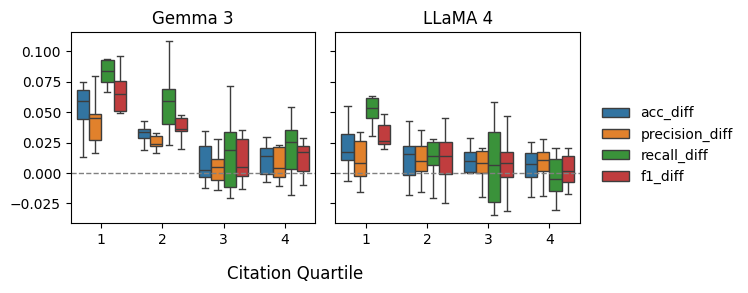

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

df_melt = metrics_df.melt(
    id_vars=['quartile', 'feature', 'cv_fold'],
    value_vars=['acc_diff', 'precision_diff', 'recall_diff', 'f1_diff'],
    var_name='metric',
    value_name='value'
)

model_names = [('gemma3', 'Gemma 3'), ('llama4', 'LLaMA 4')]

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (model_name, ylabel) in zip(axes, model_names):
    sns.boxplot(
        data=df_melt[df_melt['feature'] == model_name],
        x='quartile',
        y='value',
        hue='metric',
        showfliers=False,
        ax=ax
    )
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=7))
    ax.set_title(ylabel)
    ax.set_ylabel('')
    ax.set_xlabel('')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='center left', bbox_to_anchor=(0.99, 0.5))
for ax in axes:
    ax.get_legend().remove()

fig.supxlabel('Citation Quartile', y=0.04)
plt.tight_layout()
plt.show()

In [137]:
fig.savefig(home / 'projects/TLDR/bias/citation_sub.pdf', bbox_inches='tight')

## Title matching 

In [188]:
import numpy as np
import pandas as pd
from transformers import DistilBertConfig, DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0)
    }

class TitlePairDataset(torch.utils.data.Dataset):
    def __init__(self, titles, contents, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            titles, contents,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

training_args = TrainingArguments(
    output_dir=home / f"bias/citation/tmp_distilbert_{feat}_split{fold_idx}",
    num_train_epochs=1,  # Set to 1 for speed; increase as needed
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    save_strategy='steps',
    learning_rate=2e-5,
    logging_strategy='no',
    disable_tqdm=True,
    report_to=[],
    seed=42
)

In [ ]:
df_q1 = df[(df['C_total']>=df['C_total'].quantile(0.75)) & (df['C_total'] <= df['C_total'].max())]
df_q2 = df[(df['C_total']>=df['C_total'].quantile(0.5)) & (df['C_total'] < df['C_total'].quantile(0.75))]
df_q3 = df[(df['C_total']>=df['C_total'].quantile(0.25)) & (df['C_total'] < df['C_total'].quantile(0.5))]
df_q4 = df[(df['C_total']>=df['C_total'].min()) & (df['C_total'] < df['C_total'].quantile(0.25))]

metrics_df_bert = pd.DataFrame(columns=[
    'quartile', 'feature', 'cv_fold',
    'f1', 'f1_ref', 'f1_diff',
    'accuracy', 'accuracy_ref', 'accuracy_diff',
    'precision', 'precision_ref', 'precision_diff',
    'recall', 'recall_ref', 'recall_diff'
])

for i, df_q in enumerate([df_q1, df_q2, df_q3, df_q4]):
    print(f"\nProcessing quartile {i+1}")
    print(len(df_q), "samples in this quartile")
    # --------------------------------------------------------
    pos_df = df_q.copy()
    pos_df['title_paired'] = True # 标记正样本
    
    # 收集负样本
    neg_samples = []
    rng = np.random.default_rng(42) # 固定随机种子便于复现
    for idx, row in tqdm(pos_df.iterrows(), total=len(pos_df), desc="Generating negative samples"):
        # 查找同学科标签但不同paper_id的候选title
        candidates = pos_df[(pos_df['p2v_label'] == row['p2v_label']) & (pos_df['paper_id'] != row['paper_id'])]
        if candidates.empty: # 如果没有找到同学科但不同paper_id的候选title，则查找不同学科的候选title
            print(f"Warning: No candidates found for row {idx} with p2v_label {row['p2v_label']}. Fallback to sampling from all titles.")
            candidates = pos_df[(pos_df['paper_id'] != row['paper_id'])]            
        neg_title = rng.choice(candidates['title'].values)
        neg_row = row.copy()
        neg_row['title'] = neg_title
        neg_row['title_paired'] = False
        neg_samples.append(neg_row)
    neg_df = pd.DataFrame(neg_samples)

    title_match_df = pd.concat([pos_df, neg_df], ignore_index=True) # 合并正负样本
    print(f"Total samples after pairing: {len(title_match_df)}")
    # --------------------------------------------------------
    feat = 'annotation' # Reference feature for comparison
    print(f"\nProcessing feature: {feat}")
    y = title_match_df['title_paired'].astype(int).values
    X_title = title_match_df['title'].astype(str).fillna('').values
    X_content = title_match_df[feat].astype(str).fillna('').values

    metrics_ref = {}
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_title, y)):
        print(f"  Fold {fold_idx+1}")
        X_title_train, X_title_test = X_title[train_idx].tolist(), X_title[test_idx].tolist()
        X_content_train, X_content_test = X_content[train_idx].tolist(), X_content[test_idx].tolist()
        y_train, y_test = y[train_idx], y[test_idx]

        train_dataset = TitlePairDataset(X_title_train, X_content_train, y_train, tokenizer)
        eval_dataset = TitlePairDataset(X_title_test, X_content_test, y_test, tokenizer)

        # model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
        config = DistilBertConfig(num_labels=2)
        model = DistilBertForSequenceClassification(config)

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        metrics = trainer.evaluate()
        metrics_ref[fold_idx] = {
            'accuracy': metrics['eval_accuracy'],
            'precision': metrics['eval_precision'],
            'recall': metrics['eval_recall'],
            'f1': metrics['eval_f1']
        }
    # --------------------------------------------------------
    text_features = ['abstract', 'gemma3', 'llama4']
    for feat in text_features:
        print(f"\nProcessing feature: {feat}")
        X_content = title_match_df[feat].astype(str).fillna('').values

        for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_title, y)):
            print(f"  Fold {fold_idx+1}")
            X_title_train, X_title_test = X_title[train_idx].tolist(), X_title[test_idx].tolist()
            X_content_train, X_content_test = X_content[train_idx].tolist(), X_content[test_idx].tolist()
            y_train, y_test = y[train_idx], y[test_idx]

            train_dataset = TitlePairDataset(X_title_train, X_content_train, y_train, tokenizer)
            eval_dataset = TitlePairDataset(X_title_test, X_content_test, y_test, tokenizer)

            # model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
            config = DistilBertConfig(num_labels=2)
            model = DistilBertForSequenceClassification(config)

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=eval_dataset,
                compute_metrics=compute_metrics,
            )

            trainer.train()
            metrics = trainer.evaluate()
            metrics_df_bert = pd.concat([
                metrics_df_bert,
                pd.DataFrame({
                    'quartile': [i+1],
                    'feature': [feat],
                    'cv_fold': [fold_idx+1],
                    'accuracy': [metrics['eval_accuracy']],
                    'accuracy_ref': [metrics_ref[fold_idx]['accuracy']],
                    'accuracy_diff': [metrics['eval_accuracy'] - metrics_ref[fold_idx]['accuracy']],
                    'precision': [metrics['eval_precision']],
                    'precision_ref': [metrics_ref[fold_idx]['precision']],
                    'precision_diff': [metrics['eval_precision'] - metrics_ref[fold_idx]['precision']],
                    'recall': [metrics['eval_recall']],
                    'recall_ref': [metrics_ref[fold_idx]['recall']],
                    'recall_diff': [metrics['eval_recall'] - metrics_ref[fold_idx]['recall']], 
                    'f1': [metrics['eval_f1']],
                    'f1_ref': [metrics_ref[fold_idx]['f1']],
                    'f1_diff': [metrics['eval_f1'] - metrics_ref[fold_idx]['f1']]
                })
            ], ignore_index=True)

display(metrics_df_bert)


Processing quartile 1
8547 samples in this quartile


Generating negative samples:   0%|                                                                                              | 0/8547 [00:00<?, ?it/s]

Generating negative samples:  53%|███████████████████████████████████████████                                      | 4538/8547 [00:02<00:02, 1573.09it/s]

Generating negative samples:  98%|███████████████████████████████████████████████████████████████████████████████▋ | 8415/8547 [00:05<00:00, 1635.10it/s]

Generating negative samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 8547/8547 [00:05<00:00, 1597.30it/s]


Total samples after pairing: 17094

Processing feature: annotation
  Fold 1


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.2006, 'train_samples_per_second': 647.469, 'train_steps_per_second': 10.151, 'train_loss': 0.7001745878760495, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.693358838558197, 'eval_accuracy': 0.491049491049491, 'eval_precision': 0.49171391190580027, 'eval_recall': 0.527608797379504, 'eval_f1': 0.5090293453724605, 'eval_runtime': 2.878, 'eval_samples_per_second': 2969.744, 'eval_steps_per_second': 23.28, 'epoch': 1.0}
  Fold 2


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.6011, 'train_samples_per_second': 628.405, 'train_steps_per_second': 9.852, 'train_loss': 0.7018268642140858, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6931679248809814, 'eval_accuracy': 0.49444249444249444, 'eval_precision': 0.4950859950859951, 'eval_recall': 0.565878773695296, 'eval_f1': 0.5281205635033308, 'eval_runtime': 2.8852, 'eval_samples_per_second': 2962.343, 'eval_steps_per_second': 23.222, 'epoch': 1.0}

Processing feature: gemma3
  Fold 1


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.8149, 'train_samples_per_second': 618.678, 'train_steps_per_second': 9.7, 'train_loss': 0.7018658652234433, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6933294534683228, 'eval_accuracy': 0.48356148356148354, 'eval_precision': 0.4902070509233352, 'eval_recall': 0.8198408984557791, 'eval_f1': 0.6135527928558921, 'eval_runtime': 2.8868, 'eval_samples_per_second': 2960.695, 'eval_steps_per_second': 23.209, 'epoch': 1.0}
  Fold 2


/tmp/ipykernel_3851767/4241299124.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_bert = pd.concat([
/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.8331, 'train_samples_per_second': 617.867, 'train_steps_per_second': 9.687, 'train_loss': 0.7010229309993004, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.693177342414856, 'eval_accuracy': 0.5077805077805078, 'eval_precision': 0.5104232469993683, 'eval_recall': 0.37818862625789845, 'eval_f1': 0.4344669982524533, 'eval_runtime': 2.9198, 'eval_samples_per_second': 2927.223, 'eval_steps_per_second': 22.947, 'epoch': 1.0}

Processing feature: llama4
  Fold 1


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.9861, 'train_samples_per_second': 611.106, 'train_steps_per_second': 9.581, 'train_loss': 0.7009635469806728, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6932271122932434, 'eval_accuracy': 0.4988884988884989, 'eval_precision': 0.4989912575655683, 'eval_recall': 0.5208235844642022, 'eval_f1': 0.5096737263880938, 'eval_runtime': 2.9125, 'eval_samples_per_second': 2934.641, 'eval_steps_per_second': 23.005, 'epoch': 1.0}
  Fold 2


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.9141, 'train_samples_per_second': 614.27, 'train_steps_per_second': 9.631, 'train_loss': 0.7018576664711113, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6933311223983765, 'eval_accuracy': 0.4954954954954955, 'eval_precision': 0.4972852568564667, 'eval_recall': 0.835946641703721, 'eval_f1': 0.6236033519553073, 'eval_runtime': 2.9076, 'eval_samples_per_second': 2939.495, 'eval_steps_per_second': 23.043, 'epoch': 1.0}

Processing quartile 2
8560 samples in this quartile


Generating negative samples:  21%|████████████████▉                                                                | 1786/8560 [00:01<00:04, 1666.59it/s]

Generating negative samples:  90%|████████████████████████████████████████████████████████████████████████▋        | 7682/8560 [00:04<00:00, 1825.74it/s]

Generating negative samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 8560/8560 [00:05<00:00, 1688.93it/s]


Total samples after pairing: 17120

Processing feature: annotation
  Fold 1


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 14.0501, 'train_samples_per_second': 609.246, 'train_steps_per_second': 9.537, 'train_loss': 0.7038434726088795, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6935157179832458, 'eval_accuracy': 0.5001168224299065, 'eval_precision': 0.5263157894736842, 'eval_recall': 0.002336448598130841, 'eval_f1': 0.0046522447080716445, 'eval_runtime': 2.9045, 'eval_samples_per_second': 2947.118, 'eval_steps_per_second': 23.067, 'epoch': 1.0}
  Fold 2


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.6622, 'train_samples_per_second': 626.546, 'train_steps_per_second': 9.808, 'train_loss': 0.7041374889772329, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6933340430259705, 'eval_accuracy': 0.5063084112149533, 'eval_precision': 0.5202095808383234, 'eval_recall': 0.16238317757009346, 'eval_f1': 0.2475071225071225, 'eval_runtime': 2.9012, 'eval_samples_per_second': 2950.511, 'eval_steps_per_second': 23.094, 'epoch': 1.0}

Processing feature: gemma3
  Fold 1


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 13.7819, 'train_samples_per_second': 621.105, 'train_steps_per_second': 9.723, 'train_loss': 0.7041507550139925, 'epoch': 1.0}


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6931760311126709, 'eval_accuracy': 0.5092289719626168, 'eval_precision': 0.5293680297397769, 'eval_recall': 0.16635514018691588, 'eval_f1': 0.2531555555555556, 'eval_runtime': 2.9139, 'eval_samples_per_second': 2937.623, 'eval_steps_per_second': 22.993, 'epoch': 1.0}
  Fold 2


/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

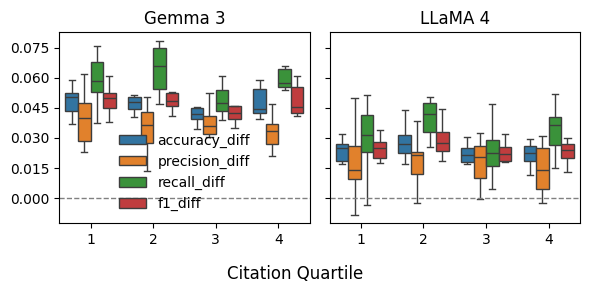

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

df_melt = metrics_df_bert.melt(
    id_vars=['quartile', 'feature', 'cv_fold'],
    value_vars=['accuracy_diff', 'precision_diff', 'recall_diff', 'f1_diff'],
    var_name='metric',
    value_name='value'
)

model_names = [('gemma3', 'Gemma 3'), ('llama4', 'LLaMA 4')]

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (model_name, ylabel) in zip(axes, model_names):
    sns.boxplot(
        data=df_melt[df_melt['feature'] == model_name],
        x='quartile',
        y='value',
        hue='metric',
        showfliers=False,
        ax=ax
    )
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=7))
    ax.set_title(ylabel)
    ax.set_ylabel('')
    ax.set_xlabel('')

# Optional: tidy up legends (show only one)
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    ax.get_legend().remove()
axes[0].legend(handles, labels, frameon=False)

fig.supxlabel('Citation Quartile', y=0.04)
plt.tight_layout()
plt.show()

### No CV

In [10]:
df_q1 = df[(df['C_total']>=df['C_total'].quantile(0.75)) & (df['C_total'] <= df['C_total'].max())]
df_q2 = df[(df['C_total']>=df['C_total'].quantile(0.5)) & (df['C_total'] < df['C_total'].quantile(0.75))]
df_q3 = df[(df['C_total']>=df['C_total'].quantile(0.25)) & (df['C_total'] < df['C_total'].quantile(0.5))]
df_q4 = df[(df['C_total']>=df['C_total'].min()) & (df['C_total'] < df['C_total'].quantile(0.25))]

In [52]:
import torch
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# 设定设备
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 评价指标
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

class TitlePairDataset(torch.utils.data.Dataset):
    def __init__(self, titles, contents, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            titles, contents,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

model_name = 'albert/albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [53]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

for i, df_q in enumerate([df_q1, df_q2, df_q3, df_q4]):
    print(f"\nProcessing quartile {i + 1} with {len(df_q)} samples")
    # --------------------------------------------------------
    pos_df = df_q.copy()

    # 标记正样本
    pos_df['title_paired'] = True
    # 收集负样本
    neg_samples = []
    rng = np.random.default_rng(42) # 固定随机种子便于复现
    for idx, row in tqdm(pos_df.iterrows(), total=len(pos_df), desc="Generating negative samples"):
        # 查找同学科标签但不同paper_id的候选title
        candidates = pos_df[(pos_df['p2v_label'] == row['p2v_label']) & (pos_df['paper_id'] != row['paper_id'])]
        if candidates.empty: # 如果没有找到同学科但不同paper_id的候选title，则查找不同学科的候选title
            print(f"Warning: No candidates found for row {idx} with p2v_label {row['p2v_label']}. Fallback to sampling from all titles.")
            candidates = pos_df[(pos_df['paper_id'] != row['paper_id'])]            
        neg_title = rng.choice(candidates['title'].values)
        neg_row = row.copy()
        neg_row['title'] = neg_title
        neg_row['title_paired'] = False
        neg_samples.append(neg_row)
    neg_df = pd.DataFrame(neg_samples)
    # 合并正负样本
    title_match_df = pd.concat([pos_df, neg_df], ignore_index=True)
    print(f"Total samples after pairing: {len(title_match_df)}")
    # --------------------------------------------------------

    text_features = ['annotation'] + models 
    y = title_match_df['title_paired'].astype(int).values
    results = []

    for feat in text_features:
        print(f"\nProcessing feature: {feat}")
        output_dir = home / f'projects/TLDR/evaluation/bias/cached_title_modernbert_{feat}' / 'no_cv'
        output_dir_str = str(output_dir)
        X_title = title_match_df['title'].astype(str).fillna('').tolist()
        X_content = title_match_df[feat].astype(str).fillna('').tolist()
        labels = y

        # dataset split
        train_titles, test_titles, train_contents, test_contents, train_labels, test_labels = train_test_split(
            X_title, X_content, labels, test_size=0.2, random_state=42, stratify=labels
        )

        # construct datasets
        train_dataset = TitlePairDataset(train_titles, train_contents, train_labels, tokenizer)
        test_dataset = TitlePairDataset(test_titles, test_contents, test_labels, tokenizer)

        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
        training_args = TrainingArguments(
            output_dir=output_dir_str,
            num_train_epochs=1,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            eval_strategy='no',
            save_strategy='no',
            logging_strategy='no',
            disable_tqdm=True,
            report_to=[],
            load_best_model_at_end=False,
            seed=42
        )
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        eval_result = trainer.evaluate()

        # 汇总
        res = {
            'feature': feat,
            'Accuracy': eval_result['eval_accuracy'],
            'Precision': eval_result['eval_precision'],
            'Recall': eval_result['eval_recall'],
            'F1': eval_result['eval_f1'],
        }
        results.append(res)

    results_df = pd.DataFrame(results)
    display(results_df)
    print("gemma3 performance diff:", 
          results_df[results_df['feature']=='gemma3'].F1.values[0] - results_df[results_df['feature']=='annotation'].F1.values[0])
    print("llama4 performance diff:", 
          results_df[results_df['feature']=='llama4'].F1.values[0] - results_df[results_df['feature']=='annotation'].F1.values[0])


Processing quartile 1 with 8547 samples


Generating negative samples:   2%|█▉                                                                                                                           | 136/8547 [00:00<00:06, 1359.82it/s]

Generating negative samples:  53%|█████████████████████████████████████████████████████████████████▏                                                          | 4493/8547 [00:02<00:02, 1559.18it/s]

Generating negative samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 8509/8547 [00:05<00:00, 1622.62it/s]

Generating negative samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8547/8547 [00:05<00:00, 1583.43it/s]


Total samples after pairing: 17094

Processing feature: annotation


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py", line 97, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/models/albert/modeling_albert.py", line 1034, in forward
    outputs = self.albert(
              ^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/models/albert/modeling_albert.py", line 712, in forward
    encoder_outputs = self.encoder(
                      ^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/models/albert/modeling_albert.py", line 524, in forward
    layer_group_output = self.albert_layer_groups[group_idx](
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/models/albert/modeling_albert.py", line 476, in forward
    layer_output = albert_layer(hidden_states, attention_mask, head_mask[layer_index], output_attentions)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/models/albert/modeling_albert.py", line 441, in forward
    ffn_output = apply_chunking_to_forward(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/pytorch_utils.py", line 250, in apply_chunking_to_forward
    return forward_fn(*input_tensors)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/models/albert/modeling_albert.py", line 453, in ff_chunk
    ffn_output = self.activation(ffn_output)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/zqlyu/lib/python3.12/site-packages/transformers/activations.py", line 47, in forward
    return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))
           ~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 44.43 GiB of which 53.00 MiB is free. Process 2632990 has 38.57 GiB memory in use. Including non-PyTorch memory, this process has 5.80 GiB memory in use. Of the allocated memory 4.62 GiB is allocated by PyTorch, and 184.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


# Tail